In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

data_directory = "/Users/nepal/Documents/synapthesis/synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
procedura_fn = "/Users/nepal/Documents/synapthesis/tipi_procedure.txt"

lotti = pd.read_csv(path.join(data_directory, lotti_fn), index_col="id_lotto")
vincitori = pd.read_csv(path.join(data_directory, vincitori_fn), index_col="id_lotto")
tipi_procedura = pd.read_csv(procedura_fn, index_col="id_scelta_contraente")

lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti.data_inferita = pd.to_datetime(lotti.data_inferita, yearfirst=True)

# Data preparation

## lotti dataframe

In [2]:
lotti = utils.replace_missing_value(lotti, "importo", "importo_base_asta")

importo values to substitute:           0.0012%


In [3]:
lotti = utils.replace_missing_value(lotti, "data_inizio", "data_inferita")

data_inizio values to substitute:           0.3145%


In [4]:
# drop non relevante table attributes
lotti = lotti.drop(columns=["oggetto", "importo_liquidato", "importo_base_asta", "data_inferita", "id_mod_realizz", "cpv_vero"])

per il momento scarto tutte le transazioni con almeno un missing value.
eventualmente quando non mi servirà la durata, tornerò indietro. 

In [5]:
lotti = lotti.dropna()

In [6]:
# cast to int64 cols now w/out np.nan
lotti.id_scelta_contraente = lotti.id_scelta_contraente.astype('int')
lotti.id_lsf = lotti.id_lsf.astype('int')
lotti.cpv = lotti.cpv.astype('int')

## vincitori dataframe


In [7]:
vincitori = vincitori.dropna()

## lotti merge vincitori merge tipi_procedura

In [8]:
df = lotti.merge(vincitori, on="id_lotto", how="inner", suffixes=("_pa", "_be"))
df = df.join(tipi_procedura, on="id_scelta_contraente", how="left")

# feature extraction

`groupby(col).median()` computes the median for each row. 

In [9]:
# erogato mediano annuo pa
df = utils.extract_med_rev_by_year(df, "id_pa")

In [10]:
# fatturato mediano annuo fornitori
df = utils.extract_med_rev_by_year(df, "id_be")

In [11]:
# median contract for each buyer (PA) and supplier (business entities)
df = utils.extract_med_contract(df, "id_pa")
df = utils.extract_med_contract(df, "id_be")

In [12]:
# durata
df['durata'] = df.data_fine - df.data_inizio

# extract year, month
df['year'] = df.data_inizio.dt.year
df['month'] = df.data_inizio.dt.month

In [13]:
# encode day of the year as (sin cosine)
df = utils.encode_sin_cos(df, "year")

In [14]:
# numero mediano di contratti per anno pa, be
df = utils.extract_med_n_contr_by_year(df, "id_pa")
df = utils.extract_med_n_contr_by_year(df, "id_be")

In [15]:
utils.print_df_measures(df)

SHAPE: (755757, 25)

DTYPES
id_pa                                int64
id_scelta_contraente                 int64
importo                            float64
data_inizio                 datetime64[ns]
data_fine                   datetime64[ns]
id_lsf                               int64
id_forma_giuridica_pa                int64
uber_forma_giuridica_pa             object
cpv                                  int64
id_be                                int64
id_forma_giuridica_be                int64
uber_forma_giuridica_be             object
procedura                           object
tipo_procedura                      object
erogato_med_pa                     float64
fatt_med_be                        float64
contr_med_pa                       float64
contr_med_be                       float64
durata                     timedelta64[ns]
year                                 int64
month                                int64
year_sin                           float64
year_cos                  

# data visualization

plot the log10 of the importo for visualization purposes

variabili da plottare; dato un cpv
* importo contratto
* durata 
* contratto mediano annuo pa | be 
* fatturato mediano annuo pa | be
* tipo procedura
* forma giuridica pa | be 

triplets: per la scoperta di correlazioni / regole per l'eliminazione di outlier ovvi
1. (importo contratto, durata, tipo procedura) più grande l'importo, più lunga la durata?
2. (durata, fatturato mediano be, tipo procedura) più lunga la durata, più grande è l'azienda?
2. (importo contratto, contratto mediano pa, tipo procedura) più grande l'importo, più grande la pa?
2. (importo contratto, contratto mediano be, tipo procedura) più grande l'importo, più grande la be?
6. (fatturato mediano annuo be, erogato mediano, tipo procedura) più grande è la pa, più tende a farsi rifornire da grandi be? 

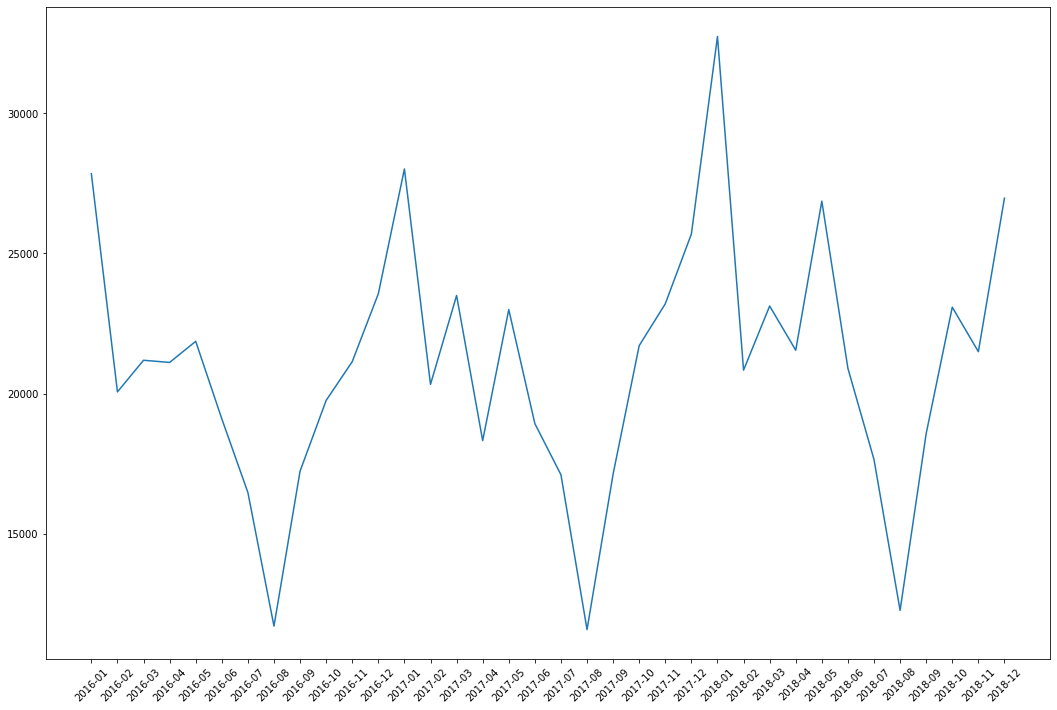

In [16]:
plt.figure(figsize=(6*3, 4*3))
plt.plot(df.groupby(df.data_inizio.dt.to_period("M")).size().values)
plt.xticks(ticks=list(range(df.groupby(df.data_inizio.dt.to_period("M")).size().shape[0])), 
           labels=df.groupby(df.data_inizio.dt.to_period("M")).size().index,
          rotation=45)
plt.show()

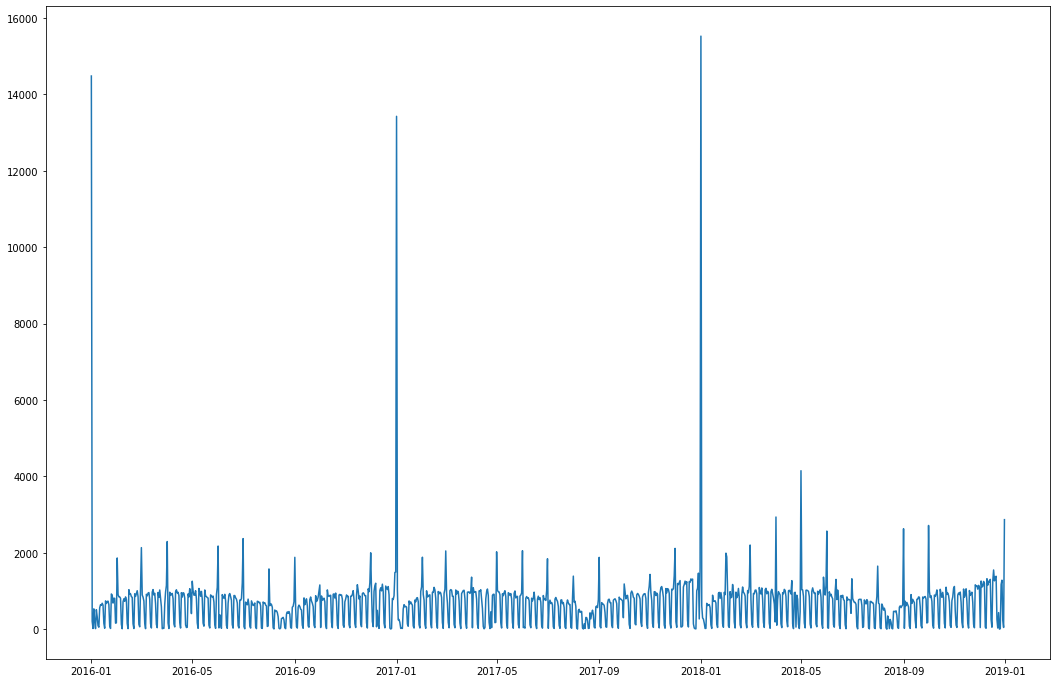

In [17]:
plt.figure(figsize=(6*3, 4*3))
plt.plot(df.groupby("data_inizio").size())

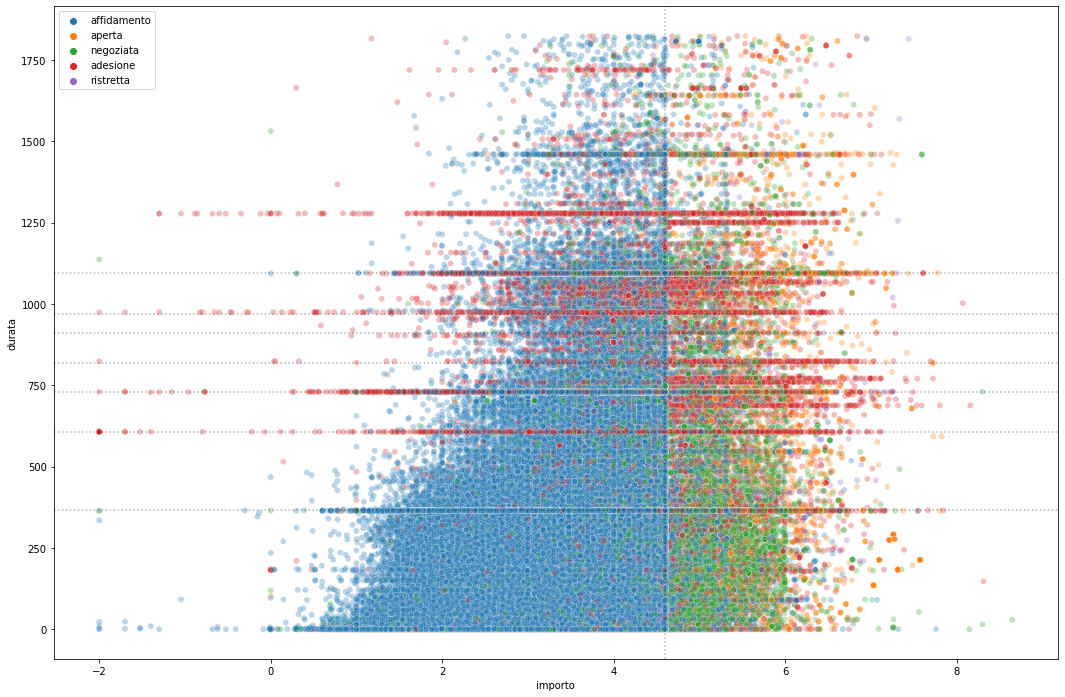

In [18]:
th = 365*5
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df[df.durata.dt.days < th].importo),
    y=df[df.durata.dt.days < th].durata.dt.days,
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(10e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.3)
plt.axhline(365, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*6, color='black', linestyle="dotted", alpha=.3)
# ci sono perodicità annuali
plt.legend(loc='upper left')
plt.show()

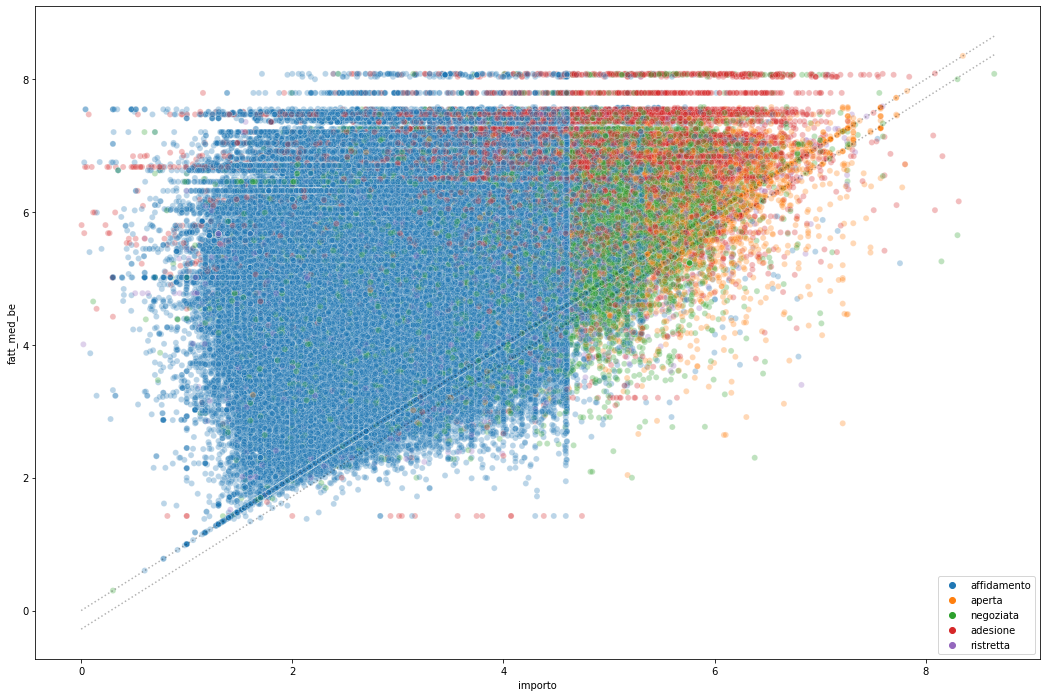

In [19]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0], 
    y=np.log10(df.fatt_med_be)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)

x = np.linspace(0, np.log10(df.importo).max())
# il fatturato dell'azienda coincide con l'importo di un singolo contratto
plt.plot(x, x, color='black', linestyle="dotted", alpha=.3) 
# x - .28 corrisponde a np.log10(df.importo - df.importo * (1 - 10**(-.28))), 
# sono aziende che chiudono un solo contratto all'anno, ma l'importo mediano è inferiore di (1-10^(-.28))
# questo implica che tali aziende hanno applicato un sovrapprezzo a quella stessa fornitura almeno in un anno
plt.plot(x, x - .28, color='black', linestyle="dotted", alpha=.3) 
plt.legend(loc="lower right")
plt.show()

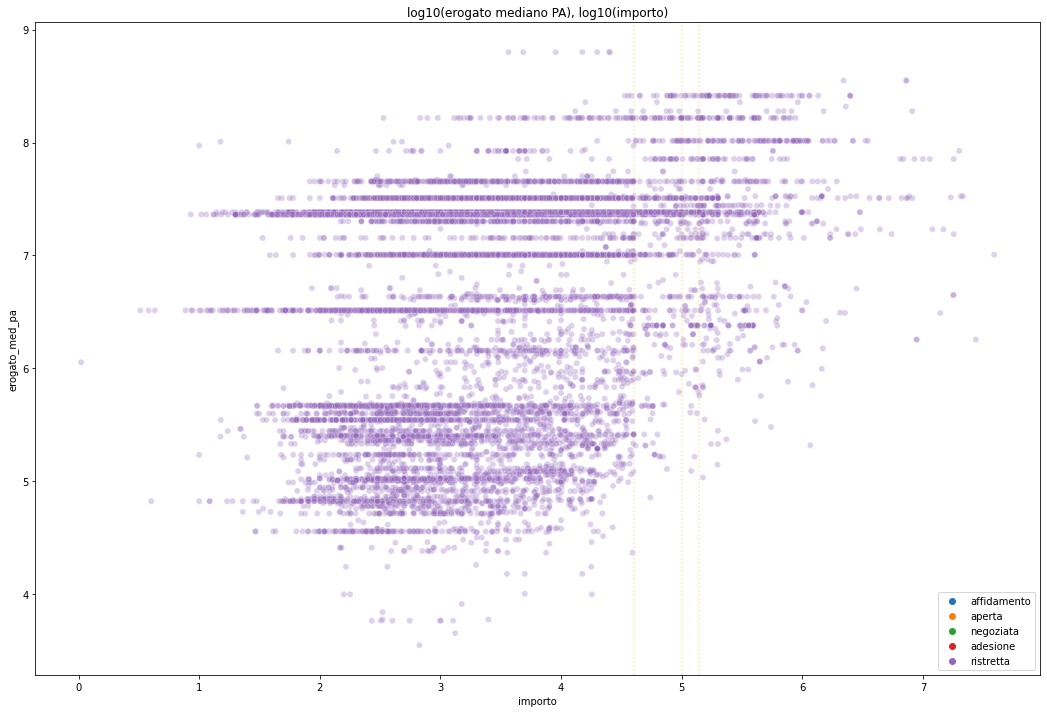

In [20]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "ristretta"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(10e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(4e4), color='orange', linestyle="dotted", alpha=.3)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

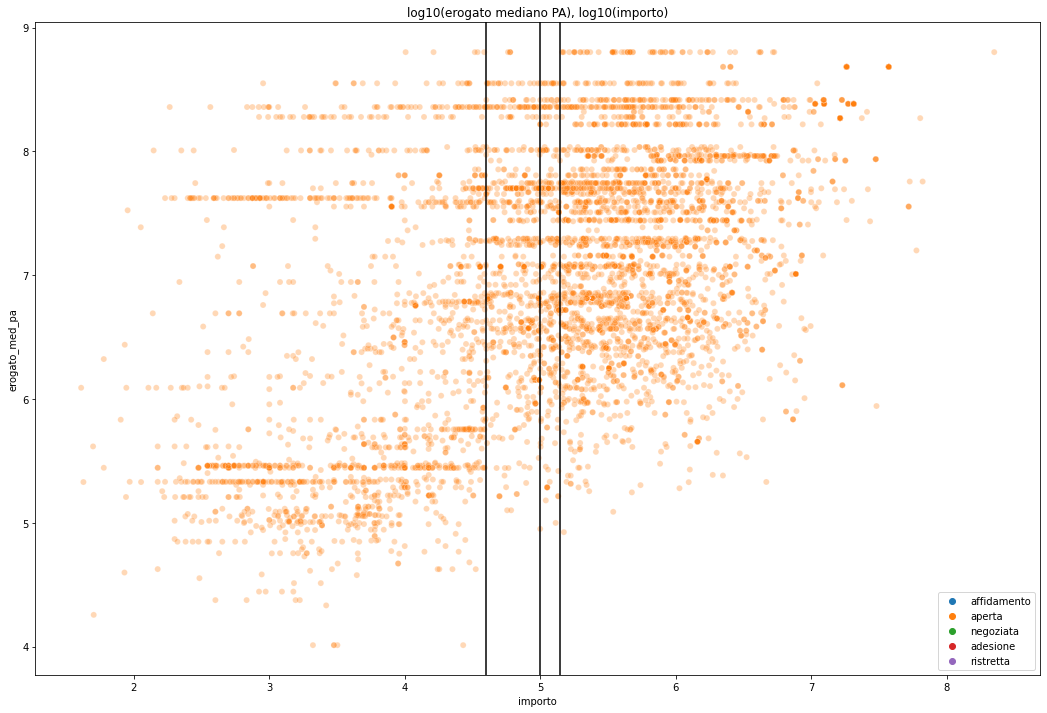

In [21]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "aperta"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='black')
plt.axvline(np.log10(10e4), color='black')
plt.axvline(np.log10(4e4), color='black')
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

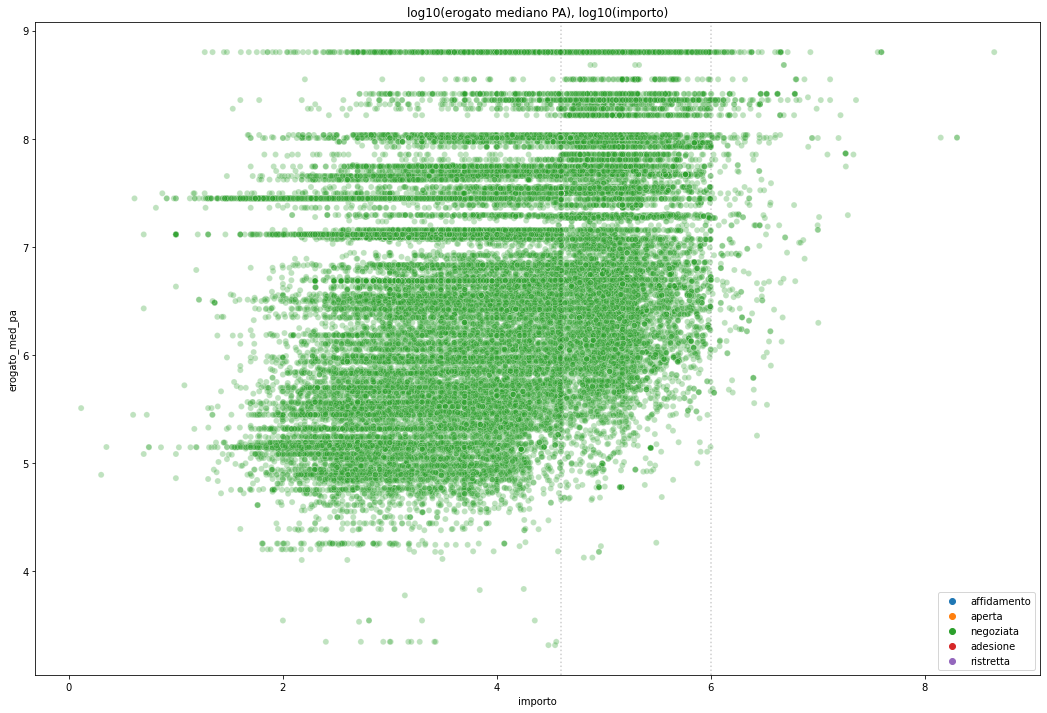

In [22]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "negoziata"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

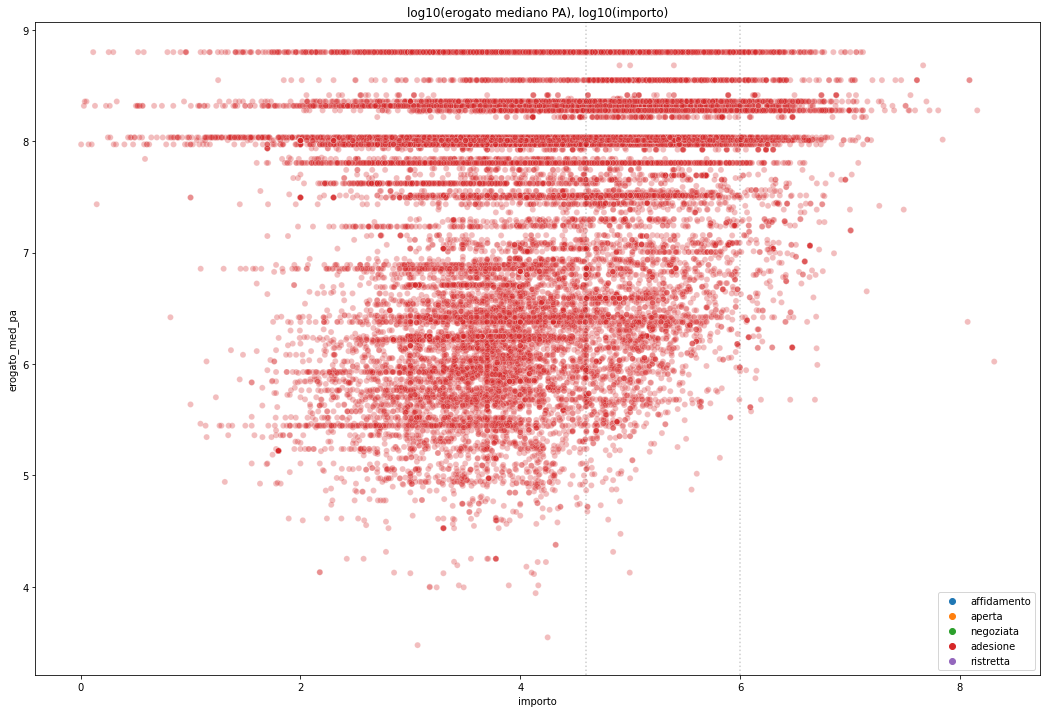

In [23]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "adesione"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

In [24]:
# top 5 cpv by occurrences
df.groupby("cpv").size().iloc[df.groupby('cpv').size().argsort()][::-1][:5]

cpv
33    88586
50    53837
30    44448
22    37652
45    32560
dtype: int64

* 33: apparecchiature mediche
* 50: servizi di riparazione e manutenzione
* 30: Macchine per ufficio ed elaboratori elettronici, attrezzature e forniture, esclusi i mobili e i pacchetti software

controllare per contratto mediano per fornitore. 

visualizzare le macro aree cpv

regole: contratti più alti del fatturato mediano e erogato mediano, sono sbagliati (controllare la soglia minima di contratti per azienda). visualizzare gli errati per tipo di procedura e uber_stazione 

# regole per l'eliminazione di outlier
1. contratti più grandi del valore mediano della pa e dell'azienda fornitrice aventi un numero minimo di contratti da valutare (ma il numero di contratti per anno?)
2. affidamenti diretti che durano più di x anni.
3. contratti aventi importi di ordine di grandezza 2 volte superiori al fatturato mediano della be

In [26]:
# regola uno
pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)
min_year_contr_th = 10
mask_fatt = (df.importo > df.erogato_med_pa) & (df.importo > df.fatt_med_be)
# mask_contr = df.med_yearly_n_contr_be.between(1, min_year_contr_th) & df.med_yearly_n_contr_pa.between(1, min_year_contr_th) 
mask_contr = (df.med_yearly_n_contr_be > min_year_contr_th) & (df.med_yearly_n_contr_pa > min_year_contr_th)
df[mask_fatt & mask_contr][["importo", "erogato_med_pa", "fatt_med_be", "med_yearly_n_contr_be", "med_yearly_n_contr_pa"]]

,importo,erogato_med_pa,fatt_med_be,med_yearly_n_contr_be,med_yearly_n_contr_pa
21273,351.20k,59.47k,51.82k,28.00,77.00
60690,5.47M,3.47M,263.40k,83.00,340.00
92470,8.48M,4.50M,7.78M,11.00,49.00
132428,59.92M,15.85M,2.35M,12.00,36.00
138658,2.25M,964.42k,2.09M,81.00,85.00
178437,837.99k,748.06k,429.92k,49.00,184.00
184099,6.23M,2.05M,6.67k,11.00,75.00
286200,115.41k,42.31k,36.55k,24.00,69.00
300358,57.05M,1.39M,169.66k,21.00,213.00
312636,117.78M,2.39M,14.21M,361.00,16.00


questi sembrano tutti sbagliati

In [31]:
min_n_contr = 5,
max_n_contr = 10
mask_fatt = (df.importo > df.erogato_med_pa) & (df.importo > df.fatt_med_be)
mask_contr = df.med_yearly_n_contr_be.between(min_n_contr, max_n_contr) & df.med_yearly_n_contr_pa.between(min_year_contr_th, max_n_contr) 

df[mask_fatt & mask_contr]

,id_pa,id_scelta_contraente,importo,data_inizio,data_fine,id_lsf,id_forma_giuridica_pa,uber_forma_giuridica_pa,cpv,id_be,...,fatt_med_be,contr_med_pa,contr_med_be,durata,year,month,year_sin,year_cos,med_yearly_n_contr_pa,med_yearly_n_contr_be
705276,9017,1,1.45M,2017-01-26,2018-07-30,1,15,Amministrazione regionale e locale,45,97020,...,23.27k,4.26k,1.61k,550 days,2017,1,432.78m,901.50m,10.00,5.00
705279,9017,1,1.45M,2017-01-26,2018-07-30,1,15,Amministrazione regionale e locale,45,433673,...,2.79k,4.26k,429.75,550 days,2017,1,432.78m,901.50m,10.00,6.00
705280,9017,1,1.45M,2017-01-26,2018-07-30,1,15,Amministrazione regionale e locale,45,209901,...,236.71k,4.26k,13.40k,550 days,2017,1,432.78m,901.50m,10.00,7.00


anche questi tutti sbagliati. Però è un caso che non capisco. abbiamo la stessa cifra, è un lavoro, sono tre aziende diverse, il fatturato mediano è basso è decisamente di un 1 a 3 ordini di grandezza. proabilmente qualcosa è andato storto. è sicuramente da controllare. 

In [33]:
min_n_contr = 1
max_n_contr = 5
mask_fatt = (df.importo > df.erogato_med_pa) & (df.importo > df.fatt_med_be)
mask_contr = df.med_yearly_n_contr_be.between(min_n_contr, max_n_contr) & df.med_yearly_n_contr_pa.between(min_year_contr_th, max_n_contr) 
df[mask_fatt & mask_contr][["importo", "erogato_med_pa", "fatt_med_be", "med_yearly_n_contr_be", "med_yearly_n_contr_pa"]]

,importo,erogato_med_pa,fatt_med_be,med_yearly_n_contr_be,med_yearly_n_contr_pa


insieme vuoto, quindi posso mettere 5 come soglia minima del numero di contratti

In [36]:
coef = 1e2
mask_coef_be = (df.importo > coef * df.fatt_med_be)
df[mask_coef_be][["importo", "erogato_med_pa", "fatt_med_be", "med_yearly_n_contr_be"]]

,importo,erogato_med_pa,fatt_med_be,med_yearly_n_contr_be
3973,990.02k,2.79M,5.35k,4.00
18402,2.81M,23.03M,16.00k,1.00
22312,5.58k,32.68M,26.56,3.00
38352,290.84k,189.71M,1.60k,1.00
42647,39.00k,930.50k,280.00,1.00
...,...,...,...,...
733372,165.00k,8.81M,100.00,1.00
740191,522.08k,1.14M,3.40k,2.00
741433,650.00k,101.71M,3.20k,2.00
745913,7.70M,10.24M,75.34k,8.00


questi sono sicuramente sbagliati. 

In [41]:
mask_coef_be = df.importo.between(5e1 * df.fatt_med_be, coef * df.fatt_med_be)
df[mask_coef_be][["importo", "erogato_med_pa", "fatt_med_be", "med_yearly_n_contr_be"]]

,importo,erogato_med_pa,fatt_med_be,med_yearly_n_contr_be
1530,620.00k,108.46M,6.50k,1.00
4881,48.00k,50.35M,900.00,1.00
8289,76.64k,93.94M,1.36k,4.00
24542,98.01k,4.40M,1.38k,1.00
31713,4.46M,101.71M,62.47k,6.00
...,...,...,...,...
738183,140.00k,228.08M,2.44k,2.00
745811,22.00k,66.34k,326.50,1.00
749010,115.00k,32.68M,1.23k,2.00
751841,233.50k,14.39M,4.57k,3.00


anche questi sembrano sbagliati

In [56]:
# affidamenti diretti oltre i 139k per servizi e forniture (art. 1 del D.L. 76/2020 e sgg mod)
mask = (df.id_scelta_contraente == 23) & (df.importo > 139e3) & (df.id_lsf != 1)
df[mask].shape[0] / df[(df.id_scelta_contraente == 23) & (df.id_lsf != 1)].shape[0] * 100

0.14920636688064046

In [57]:
# affidamenti diretti oltre i 150k per lavori (art. 1 del D.L. 76/2020 e sgg mod)
mask = (df.id_scelta_contraente == 23) & (df.importo > 150e3) & (df.id_lsf == 1) 
df[mask].shape[0] / df[(df.id_scelta_contraente == 23) & (df.id_lsf == 1)].shape[0] * 100

0.2638790216177814

percentuali di affidamenti diretti in deroga. Date le basse percentuali sono da flaggare. direi di sì.

In [63]:
# affidamenti aventi durate sopra x anni
n_years = 10
mask = (df.tipo_procedura == "affidamento") & (df.durata.dt.days > 365 * n_years)
df[mask]

,id_pa,id_scelta_contraente,importo,data_inizio,data_fine,id_lsf,id_forma_giuridica_pa,uber_forma_giuridica_pa,cpv,id_be,...,fatt_med_be,contr_med_pa,contr_med_be,durata,year,month,year_sin,year_cos,med_yearly_n_contr_pa,med_yearly_n_contr_be
15170,14385,8,165.00k,2016-04-21,2026-06-30,2,75,Ente pubblico non economico,66,131759,...,286.96k,4.50k,11.48k,3722 days,2016,4,936.88m,-349.65m,471.00,3.00
45264,6347,23,49.00k,2017-11-01,2029-11-01,1,15,Amministrazione regionale e locale,45,124712,...,49.61k,10.00k,24.81k,4383 days,2017,11,-858.76m,512.37m,104.00,2.00
65618,6691,23,22.00k,2016-08-24,2029-08-20,2,15,Amministrazione regionale e locale,90,734101,...,22.00k,700.00,22.00k,4744 days,2016,8,-806.48m,-591.26m,251.00,1.00
129180,11932,23,1.04k,2018-10-01,2028-10-01,2,15,Amministrazione regionale e locale,75,88547,...,28.84k,3.00k,3.12k,3653 days,2018,10,-999.99m,4.30m,99.00,3.00
228067,26275,23,280.00,2018-05-01,2028-04-30,2,90,Istruzione e ricerca,63,93303,...,2.10M,500.00,218.84,3652 days,2018,5,871.71m,-490.03m,154.00,2.73k
270352,12796,23,2.50k,2017-12-12,2028-12-12,3,15,Amministrazione regionale e locale,3,114744,...,3.42k,2.30k,210.66,4018 days,2017,12,-321.27m,946.99m,722.00,12.00
300443,5380,23,118.60,2018-04-13,2028-12-31,2,15,Amministrazione regionale e locale,50,246762,...,1.34k,800.00,173.57,3915 days,2018,4,979.61m,-200.89m,193.00,4.00
312704,33034,23,450.00,2018-09-01,2029-09-01,2,176,Società privata e cooperazione fra imprese,66,109711,...,32.42k,4.24k,270.00,4018 days,2018,9,-871.71m,-490.03m,2.93k,24.00
334892,11348,23,31.48k,2018-11-29,2028-12-31,2,15,Amministrazione regionale e locale,75,100040,...,25.22k,1.35k,1.55k,3685 days,2018,11,-523.42m,852.08m,207.00,7.00
350571,14385,8,100.00k,2016-04-21,2026-06-30,2,75,Ente pubblico non economico,66,131759,...,286.96k,4.50k,11.48k,3722 days,2016,4,936.88m,-349.65m,471.00,3.00


questi sono errati

<AxesSubplot:xlabel='cpv', ylabel='count'>

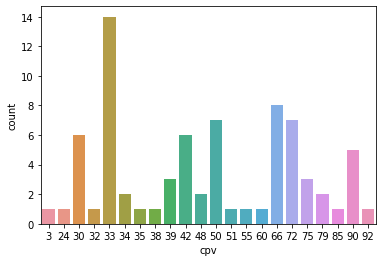

In [72]:
min_years = 5
mask = (df.tipo_procedura == "affidamento") & (df.durata.dt.days.between(365 * min_years, 365 * n_years)) & (df.importo > 25e3)
sns.countplot(data = df[mask], x="cpv")